In [1]:
import torch
from transformers import pipeline as model
from PIL import Image
import matplotlib.pyplot as plt
import shap
import numpy as np

## Load the model

In [2]:
pipeline = model(
    task="image-classification",
    model="google/mobilenet_v2_1.4_224",
    device=0
)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cpu


In [3]:
pipeline("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/pipeline-cat-chonk.jpeg")

[{'label': 'lynx, catamount', 'score': 0.48987439274787903},
 {'label': 'tiger cat', 'score': 0.0541708841919899},
 {'label': 'tiger, Panthera tigris', 'score': 0.022036202251911163},
 {'label': 'wombat', 'score': 0.0200725719332695},
 {'label': 'tabby, tabby cat', 'score': 0.019137298688292503}]

## Choose the images

In [4]:
images_path = "data/"

In [5]:
images = [Image.open(images_path + "img_{}.jpg".format(i)) for i in range(1, 4)]

## Make predictions

In [6]:
predictions = pipeline(images, top_k=5)


Resultados para img_1.jpg:


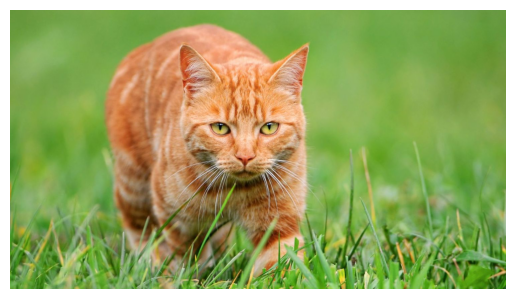

  tiger cat: 0.7235
  tabby, tabby cat: 0.1509
  Egyptian cat: 0.0145
  Persian cat: 0.0025
  ping-pong ball: 0.0014

----------------------------------------------------------------------

Resultados para img_2.jpg:


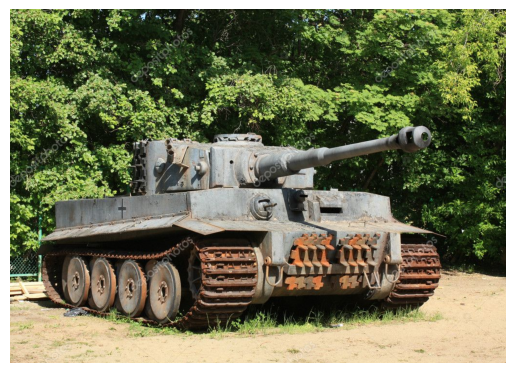

  tank, army tank, armored combat vehicle, armoured combat vehicle: 0.8066
  cannon: 0.0193
  amphibian, amphibious vehicle: 0.0070
  half track: 0.0062
  mortar: 0.0043

----------------------------------------------------------------------

Resultados para img_3.jpg:


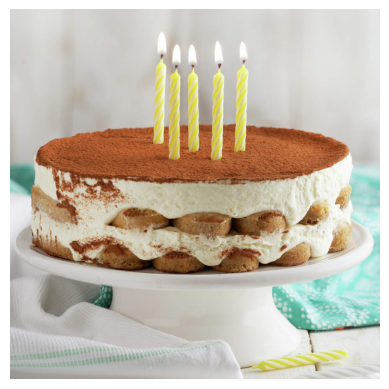

  candle, taper, wax light: 0.2055
  trifle: 0.1093
  potpie: 0.0449
  ice cream, icecream: 0.0377
  matchstick: 0.0374

----------------------------------------------------------------------


In [7]:
for i, preds in enumerate(predictions, 1):
    print(f"\nResultados para img_{i}.jpg:")
    plt.imshow(images[i-1])
    plt.axis('off')
    plt.show()
    for p in preds:
        print(f"  {p['label']}: {p['score']:.4f}")
    print("\n" + "-"*70)

## SHAP Explainer

In [8]:
hf_model = pipeline.model
device_torch = hf_model.device
processor = getattr(pipeline, "image_processor", None) or getattr(pipeline, "feature_extractor", None)
id2label = hf_model.config.id2label
CLASS_ORDER = [id2label[i] for i in sorted(id2label.keys())]
_label_to_idx = {lbl: i for i, lbl in enumerate(CLASS_ORDER)}
N_CLASSES = len(CLASS_ORDER)

In [9]:
H = processor.size.get("height", 224)
W = processor.size.get("width", 224)

In [10]:
def _to_pil_rgb(x):
    if isinstance(x, Image.Image):
        return x.convert("RGB")
    arr = np.array(x)
    if arr.ndim == 2:
        arr = np.stack([arr, arr, arr], axis=-1)
    return Image.fromarray(arr.astype(np.uint8)).convert("RGB")

In [11]:
def _prepare_img_for_shap(pil_img):
    # reducimos a 224x224 para que el masker no cree millones de features
    return np.array(_to_pil_rgb(pil_img).resize((W, H), Image.BILINEAR))


In [12]:
@torch.no_grad()
def hf_predict_proba(batch_hwc):
    """
    batch_hwc: (N,H,W,3) np.array o lista de PIL/arrays
    -> (N, N_CLASSES) probabilidades en orden CLASS_ORDER
    """
    if isinstance(batch_hwc, np.ndarray) and batch_hwc.ndim == 3:
        batch = [_to_pil_rgb(batch_hwc)]
    elif isinstance(batch_hwc, np.ndarray) and batch_hwc.ndim == 4:
        batch = [_to_pil_rgb(img) for img in batch_hwc]
    elif isinstance(batch_hwc, list):
        batch = [_to_pil_rgb(img) for img in batch_hwc]
    else:
        batch = [_to_pil_rgb(batch_hwc)]

    inputs = processor(images=batch, return_tensors="pt")
    model_dtype = next(hf_model.parameters()).dtype
    inputs = {k: v.to(device_torch) for k, v in inputs.items()}
    if inputs["pixel_values"].dtype != model_dtype:
        inputs["pixel_values"] = inputs["pixel_values"].to(model_dtype)

    logits = hf_model(**inputs).logits
    probs = torch.softmax(logits, dim=-1).cpu().numpy().astype(np.float32)
    return probs

In [13]:
img0_small = _prepare_img_for_shap(images[0])
masker = shap.maskers.Image("blur(20,20)", img0_small.shape)
explainer = shap.Explainer(hf_predict_proba, masker, algorithm="partition")

In [14]:
def shap_topk_for_image(pil_image, top_k=5, width=14, max_evals=300, batch_size=50):
    img_small = _prepare_img_for_shap(pil_image)                 # (224,224,3)
    probs = hf_predict_proba(np.array([img_small]))[0]
    topk_idx = probs.argsort()[::-1][:top_k]

    # limitar salidas y evaluaciones
    sv = explainer(
        np.array([img_small]),
        outputs=topk_idx,          # Top-K clases
        max_evals=max_evals,       # reduce número de evaluaciones
        batch_size=batch_size,     # evalúa en lotes
        silent=True
    )

    vals = sv.values              # (1,H,W,C,K_top) o (1,H,W,K_top)
    if vals.ndim == 4:            # (1,H,W,K_top) -> añadir canal ficticio
        vals = vals[..., None, :]

    outs = [vals[..., k] for k in range(vals.shape[-1])]
    shap.image_plot(outs, pixel_values=np.array([img_small]), width=width)

    print("Top-{} clases explicadas:".format(top_k))
    for k in topk_idx:
        print(f"  {CLASS_ORDER[k]}: {probs[k]:.4f}")


============ SHAP para img_1.jpg ============


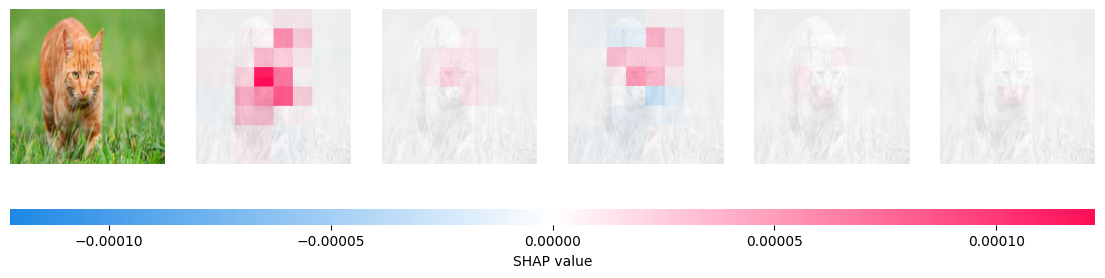

Top-5 clases explicadas:
  tiger cat: 0.5124
  tabby, tabby cat: 0.0917
  Egyptian cat: 0.0845
  lynx, catamount: 0.0249
  Persian cat: 0.0057

============ SHAP para img_2.jpg ============


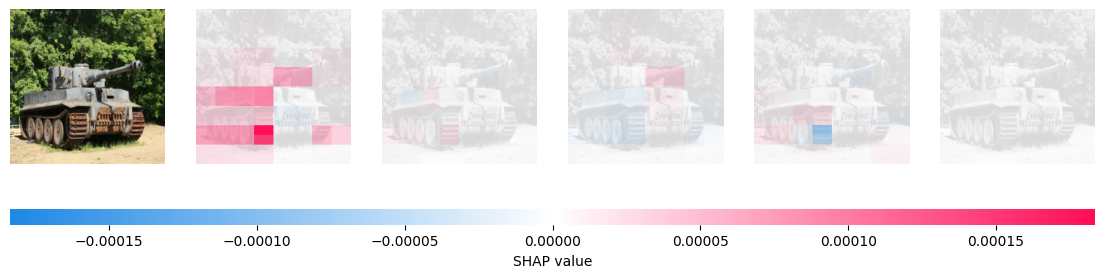

Top-5 clases explicadas:
  tank, army tank, armored combat vehicle, armoured combat vehicle: 0.9294
  half track: 0.0053
  cannon: 0.0039
  amphibian, amphibious vehicle: 0.0032
  harvester, reaper: 0.0009

============ SHAP para img_3.jpg ============


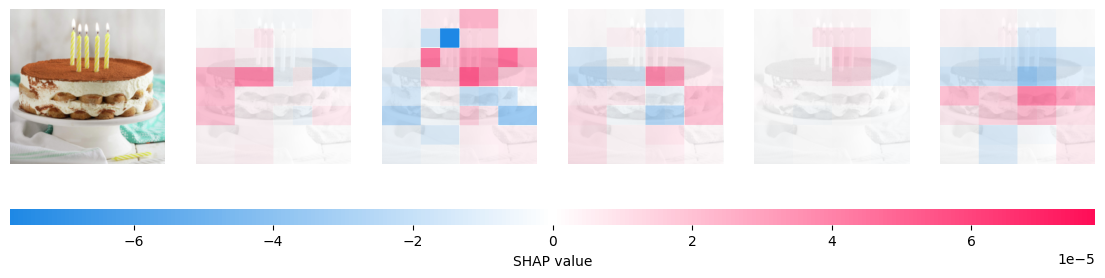

Top-5 clases explicadas:
  trifle: 0.1649
  candle, taper, wax light: 0.1430
  potpie: 0.0880
  matchstick: 0.0324
  eggnog: 0.0192


In [15]:
for i, im in enumerate(images, 1):
    print("\n" + "="*12 + f" SHAP para img_{i}.jpg " + "="*12)
    shap_topk_for_image(im, top_k=5, width=14, max_evals=300, batch_size=50)

## REFLEXIÓN

En la primera imagen (gato), el modelo predijo con alta probabilidad la clase *tiger cat*, y los mapas de SHAP muestran que las regiones que más contribuyeron a la decisión están en el rostro, las orejas y el patrón del pelaje. Estas son precisamente las partes más distintivas para reconocer un felino, lo que indica que el modelo se enfocó en las áreas correctas y no dependió en exceso del fondo. Las zonas en azul, asociadas al césped, restan importancia a la predicción, lo cual es coherente ya que el fondo no debería definir la clase.

En la segunda imagen (tanque), la predicción fue muy segura a favor de la clase *tank*. Los valores de SHAP señalan que el modelo se apoyó en la torreta, el cañón y las orugas, elementos clave para identificar un vehículo blindado de combate. Las demás clases alternativas (como *half track* o *cannon*) se explican por la similitud visual de algunas partes, pero las regiones destacadas muestran que el modelo usó atributos muy relevantes.

En la tercera imagen (pastel con velas), la situación es distinta: las probabilidades de las clases están más repartidas entre *trifle*, *candle* y *potpie*, lo que refleja confusión del modelo. Los mapas de SHAP muestran contribuciones en la parte superior del pastel y en las velas, lo cual es relevante, pero también se observan regiones en el plato y la base que empujan hacia otras clases. La explicación revela que el modelo identifica correctamente elementos como las velas, pero no logra diferenciar con claridad entre tipos de postres.


En conclusión, las explicaciones con SHAP confirman que el modelo tiende a fijarse en las regiones correctas de las imágenes: la cara y pelaje en el gato, la estructura principal en el tanque y las velas y parte superior en el pastel. Cuando el modelo acierta, las áreas resaltadas coinciden con los rasgos distintivos; cuando se equivoca o duda, como en el pastel, se observa que la confusión surge de características que pueden ser válidas para varias clases.